# SAR ADC

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_sar.py).This advanced example demonstrates a **SAR ADC** (Successive Approximation Register Analog-to-Digital Converter), one of the most popular ADC architectures. This example also shows how to **create custom blocks** in PathSim by extending the base `Block` class.



## Successive Approximation Register (SAR) ADC Principle

A SAR ADC converts analog signals to digital using a **binary search algorithm**:

1. **Sample** the input voltage
2. **Test** the MSB (Most Significant Bit) by comparing to DAC output
3. **Keep** the bit if comparison succeeds, **discard** if it fails
4. **Repeat** for each bit from MSB to LSB
5. **Output** the complete digital word

This requires N comparisons for N bits, making it efficient for medium-speed, medium-resolution applications (10-18 bits, up to several MHz).

## Custom SAR Logic Block

We'll implement the SAR control logic as a custom block using PathSim's event system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import (
    Adder, Scope, Source, ButterworthLowpassFilter, 
    SampleHold, Comparator, DAC
)
from pathsim.solvers import RKBS32

## Creating a Custom SAR Logic Block

This is one of PathSim's powerful features - you can create custom blocks with complex behavior. The SAR block:
- Uses **scheduled events** to step through bits
- Implements the **binary search algorithm**
- Outputs **N parallel digital signals** (one per bit)

In [2]:
from pathsim.blocks._block import Block
from pathsim.utils.register import Register
from pathsim.events import Schedule

class SAR(Block):
    """Successive Approximation Register Logic
    
    Implements SAR algorithm for ADC conversion:
    - Reads comparator result
    - Updates trial bit pattern
    - Outputs N-bit digital word
    """

    def __init__(self, n_bits=4, T=1, tau=0):
        super().__init__()

        self.n_bits = n_bits
        self.T = T
        self.tau = tau

        self.register = 0
        self.trial_weight = 1 << (self.n_bits - 1)  # Start with MSB

        self.outputs = Register(self.n_bits)

        def _step(t):
            """SAR algorithm step - executes at each clock cycle"""
            comparator_result = self.inputs[0]

            previous_weight = (self.trial_weight << 1) if self.trial_weight > 0 else 1

            # If previous comparison failed, clear that bit
            if previous_weight <= (1 << (self.n_bits -1)) and comparator_result == 0:
                self.register &= ~previous_weight 

            # Set current trial bit
            self.register |= self.trial_weight

            # Update all output bits
            for i in range(self.n_bits):
                self.outputs[i] = (self.register >> i) & 1

            # Move to next bit or restart
            if self.trial_weight == 1: 
                self.trial_weight = 1 << (self.n_bits - 1)
                self.register = 0
            else:
                self.trial_weight >>= 1

        # Schedule event for SAR stepping
        self.events = [
            Schedule(
                t_start=self.tau,
                t_period=self.T/self.n_bits,  # One step per bit
                func_act=_step
            )
        ]

    def __len__(self):
        return 0

## System Parameters

We'll use:
- **8-bit** resolution
- **50 Hz** sampling frequency
- **Modulated sine wave** as input signal

In [3]:
n = 8                 # Number of bits
f_clk = 50            # Sampling frequency
T_clk = 1.0 / f_clk   # Sampling period

## Block Diagram Setup

The system consists of:
- **src**: Modulated sine wave source
- **sah**: Sample & Hold to freeze input during conversion
- **sub**: Subtractor (input - DAC)
- **cpt**: Comparator
- **sar**: Custom SAR logic
- **dac1**: Fast DAC for comparison (updates every bit)
- **dac2**: Output DAC (updates every sample)
- **lpf**: Lowpass filter for reconstruction

In [4]:
# Blocks that define the system
src = Source(lambda t: np.sin(2*np.pi*t) * np.cos(5*np.pi*t)) 
sah = SampleHold(T=T_clk) 
sub = Adder("+-")
cpt = Comparator(span=[0, 1])
dac1 = DAC(n_bits=n, T=T_clk/n, tau=T_clk*2e-3)  # Fast DAC for comparison
dac2 = DAC(n_bits=n, T=T_clk, tau=T_clk)         # Output DAC
lpf = ButterworthLowpassFilter(f_clk/5, n=3)     # Reconstruction filter
sar = SAR(n_bits=n, T=T_clk, tau=T_clk*1e-3)
sco = Scope(labels=["src", "sah", "dac1", "dac2", "lpf"]) 

blocks = [src, cpt, dac1, dac2, lpf, sar, sah, sub, sco]

## Connections

The connections form the SAR ADC loop. Notice how the 8 digital bits from SAR connect to both DACs in parallel.

In [5]:
# Connections between the blocks
connections = [
    Connection(src, sah, sco[0]),        # Source to S&H and scope
    Connection(sah, sub[0], sco[1]),     # S&H to subtractor
    Connection(dac1, sub[1], sco[2]),    # DAC1 feedback to subtractor
    Connection(dac2, lpf, sco[3]),       # DAC2 to filter
    Connection(lpf, sco[4]),             # Filtered output
    Connection(sub, cpt),                # Difference to comparator
    Connection(cpt, sar)                 # Comparator to SAR logic
]

# Connect all N bits from SAR to both DACs
for i in range(n):
    connections.append(
        Connection(sar[i], dac1[i], dac2[i])
    )

## Simulation

We run the simulation with an adaptive solver that can handle the discrete-time events efficiently.

In [6]:
# Simulation with adaptive solver
Sim = Simulation(
    blocks,
    connections,
    Solver=RKBS32
)

# Run simulation for 1 second
Sim.run(1)

11:52:50 - INFO - LOGGING (log: True)
11:52:50 - INFO - BLOCKS (total: 9, dynamic: 1, static: 8, eventful: 5)
11:52:50 - INFO - GRAPH (nodes: 9, edges: 27, alg. depth: 3, loop depth: 0, runtime: 0.226ms)
11:52:50 - INFO - STARTING -> TRANSIENT (Duration: 1.00s)
11:52:50 - INFO - --------------------   1% | 0.0s<0.5s | 2661.8 it/s
11:52:50 - INFO - ####----------------  20% | 0.1s<0.3s | 6903.1 it/s
11:52:50 - INFO - ########------------  40% | 0.1s<0.1s | 8865.8 it/s
11:52:50 - INFO - ############--------  60% | 0.2s<0.1s | 8733.6 it/s
11:52:50 - INFO - ################----  80% | 0.2s<0.0s | 8907.2 it/s
11:52:50 - INFO - #################### 100% | 0.3s<--:-- | 8884.2 it/s
11:52:50 - INFO - FINISHED -> TRANSIENT (total steps: 2124, successful: 2034, runtime: 285.05 ms)


{'total_steps': 2124,
 'successful_steps': 2034,
 'runtime_ms': 285.04687501117587}

## Results

The plots show:
- **src**: Original analog input
- **sah**: Sampled and held signal
- **dac1**: Fast DAC during conversion (shows binary search)
- **dac2**: Output DAC (quantized signal)
- **lpf**: Reconstructed signal after filtering

Notice how dac1 shows the successive approximation steps within each sample period!

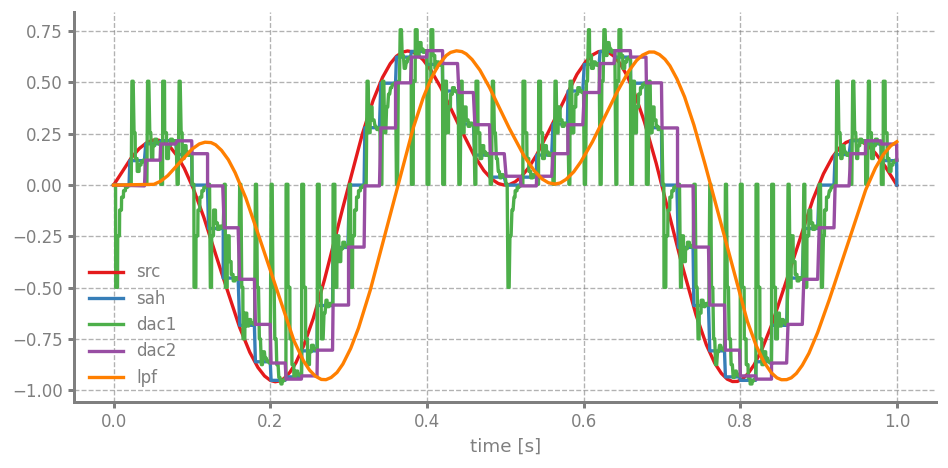

In [7]:
Sim.plot()
plt.show()